In [25]:
from typing_extensions import TypedDict, Annotated, List, Literal
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, SystemMessage
from langgraph.graph import add_messages
from typing import Dict, List, Optional, Union, Literal
from pydantic import BaseModel, Field
from IPython.display import Image, display 
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

In [26]:
## Project Requirements
class ProjectRequirements(BaseModel):
    title: str = Field(description="The title of the project")
    description: str = Field(description="The description of the project")
    requirements : List[str] = Field(description="The requirements of the project")

In [27]:
## User story
class UserStory(BaseModel):
    story_id : str = Field(description="The id of the user story")
    title : str = Field(description="The title of the user story")
    description : str = Field(description="The description of the user story")
    acceptance_criteria : List[str] = Field(description="The acceptance criteria of the user story")

In [28]:
## documents
class DocumentSection(BaseModel):
    title: str = Field(description="The title of the section")
    content: str = Field(description="The content of the section")

In [29]:
## security review
class SecurityReview(TypedDict):
    sec_id : str
    review : str
    file_path : str
    recommendation : str
    priority : Literal["high", "medium", "low"]

In [30]:
## test cases
class TestCase(TypedDict):
    test_id : str 
    description : str 
    steps : List[str]
    status : Literal["draft", "pass", "fail"] = "draft"

In [31]:
class SDLCState(BaseModel):
    project_requirements : ProjectRequirements
    
    # User story
    user_stories : List[UserStory] = []
    user_story_messages : Annotated[list, add_messages] = []
    user_story_status : Literal["pending", "in_progress", "pending_approval", "feedback", "completed"] = "pending"
    
    document_type: Literal["functional", "technical"] = "functional"

    # functional documents
    functional_document : List[DocumentSection] = []
    functional_messages : Annotated[list, add_messages] = []
    functional_status: Literal["pending", "in_progress", "pending_approval", "feedback", "completed"] = "pending"

    # technical documents
    technical_document : List[DocumentSection] = []
    technical_messages : Annotated[list, add_messages] = []
    technical_status: Literal["pending", "in_progress", "pending_approval", "feedback", "completed"] = "pending"
    
    code_type : Literal["frontend", "backend"] = "frontend"
    # frontend code
    frontend_code : str = Field(default='', description="The frontend code")
    frontend_messages: Annotated[list, add_messages] = []
    frontend_status: Literal["pending", "in_progress", "pending_approval", "feedback", "completed"] = "pending"

    # backend code
    backend_code : str = Field(default= '', description="The backend code")
    backend_messages: Annotated[list, add_messages] = []
    backend_status: Literal["pending", "in_progress", "pending_approval", "feedback", "completed"] = "pending"

    revised_count : int = Field(default=0, description="The number of times the revised")

    # security review
    security_reviews : List[SecurityReview] = []
    security_reviews_messages: Annotated[list, add_messages] = []
    security_reviews_status : Literal["pending", "in_progress", "pending_approval", "feedback", "completed"] = "pending"

    ## test cases
    test_cases : List[TestCase] = []
    test_cases_messages: Annotated[list, add_messages] = []
    test_cases_status : Literal["pending", "in_progress", "pending_approval", "feedback", "completed"] = "pending"

## Helper functions

In [32]:
def get_user_stories_from_llm(project_title, project_description, requirements):
    user_stories = [{'story_id': 'US-001',
        'title': 'Secure Account with Multi-Factor Authentication',
        'description': 'As a user, I want to secure my account with multi-factor authentication so that my transactions are protected.',
        'acceptance_criteria': ['User can enable biometric authentication (fingerprint and facial recognition).',
        'User can set up MPIN for additional security.',
        'User can enable two-factor authentication for transactions.',
        'System alerts user of authentication failures.']}]
    
    return user_stories


def revised_user_stories_from_llm():
    revised_user_stories = [{'story_id': 'US-001',
        'title': 'Secure Account with Multi-Factor Authentication',
        'description': 'As a user, I want to secure my account with multi-factor authentication so that my transactions are protected.',
        'acceptance_criteria': ['User can enable biometric authentication (fingerprint and facial recognition).',
        'User can set up MPIN for additional security.',
        'User can enable two-factor authentication for transactions.',
        'System alerts user of authentication failures.']},
        {'story_id': 'US-002',
        'title': 'Link Multiple Bank Accounts',
        'description': 'As a user, I want to link multiple bank accounts so that I can transfer funds instantly.',
        'acceptance_criteria': ['User can add multiple bank accounts to their profile.',
        'User can select any linked account for fund transfers.',
        'Linked accounts display current balance.',
        'System confirms successful linking of accounts.']}]

    return revised_user_stories

## Node functions

In [33]:
## User stories 
def process_project_requirements(state : SDLCState) -> SDLCState:
    print("In process_project_requirements...")
    return {
        "user_story_messages" : AIMessage(content="I've received your project requirements. I'll now generate user stories based on these requirements.")
    }
    
def generate_user_stories(state : SDLCState) -> SDLCState:
    print("In generate_user_stories...") 
    project_title = state.project_requirements.title
    project_description = state.project_requirements.description
    requirements = state.project_requirements.requirements
    user_stories = get_user_stories_from_llm(project_title, project_description, requirements);
    
    return {
        "user_story_status" : 'pending_approval',
        "user_stories" : user_stories,
        "user_story_messages" : AIMessage(
            content = f"Based on your requirements, I've generated {len(user_stories)} user stories. Please review these user stories and provide feedback or type 'Approved' if you're satisfied."
        ),
        "revised_count" : 0
    }

def user_stories_review(state : SDLCState) -> SDLCState:
    print("In user_stories_review...")
    user_review = state.user_story_messages[-1].content
    user_review = user_review.lower().strip()
    print("user_review : ", user_review)  
    if user_review == "approved":
        return {
            "user_story_messages" : AIMessage(content="Great! Your user stories have been finalized. You can now proceed with your design process."),
            "user_story_status" : "completed"
        }
    else:
        return {
            "user_story_messages" :  AIMessage(content="I've received your feedback. I'll revise the user stories accordingly."),
            "user_story_status" : "feedback"
        }

def should_revise_user_stories(state : SDLCState) -> Literal["feedback", "approved"]:
    return "approved" if state.user_story_status == "approved" else "feedback"   

def revised_user_stories(state : SDLCState) -> SDLCState:
    print("In revised_user_stories...")
    user_review = state.user_story_messages[-1].content
    user_review = user_review.lower().strip()
    if state.user_story_status == 'feedback':
        revised_count = state.revised_count + 1
        print("revised_count : ", revised_count)
        if revised_count == 3:
            return {
                "user_story_messages" :  AIMessage(
                    content = f"User stories have been revision maxed out. Please review the user stories and continue with the next step."
                ),
                "user_story_status" : "completed"
            }
        user_stories = revised_user_stories_from_llm(state.user_stories, user_review)
        return {
                "user_stories" : user_stories,
                "user_story_messages" : AIMessage(
                    content = "I've revised the user stories based on your feedback.\n\nPlease review these updated user stories and provide additional feedback or type 'Approved' if you're satisfied."),
                "user_story_status" : "pending_approval",
                "revised_count" : revised_count
            }

In [34]:
## Design documents
def create_design_documents(state : SDLCState) -> SDLCState:
    pass 

def design_documents_review(state : SDLCState) -> SDLCState:
    pass 

def should_revise_design_documents(state : SDLCState) -> Literal["feedback", "approved"]:
    return "approved" if state["status"] == "approved" else "feedback"   

def revised_design_documents(state : SDLCState) -> SDLCState:
    pass


In [35]:
## Generate Code 
def generate_code(state : SDLCState) -> SDLCState:
    pass 

def code_review(state : SDLCState) -> SDLCState:
    pass 

def should_fix_code(state : SDLCState) -> Literal["feedback", "approved"]:
    return "approved" if state.code_status == 'approved' else 'feedback'

def fix_code(state : SDLCState) -> SDLCState:
    pass

In [36]:
## Code review
def create_security_reviews(state : SDLCState) -> SDLCState:
    pass

def security_review(state : SDLCState) -> SDLCState:
    pass 

def fix_code_after_security_review(state : SDLCState) -> SDLCState:
    pass

In [37]:
def write_test_cases(state : SDLCState) -> SDLCState:
    pass

def test_cases_review(state : SDLCState) -> SDLCState:
    pass 

def should_fix_test_cases(state : SDLCState) -> Literal["feedback", "approved"]:
    return "approved" if state.test_cases_status == 'approved' else 'feedback'

def fixed_testcases_after_review(state : SDLCState) -> SDLCState:
    pass

In [38]:
def qa_testing(state : SDLCState) -> SDLCState:
    pass

def fixed_code_after_qa_testing(state : SDLCState) -> SDLCState:
    pass

def should_continue_qa_testing(state: SDLCState) -> Literal['passed', "failed"]:   
    return "passed" if state.qa_status == 'passed' else 'failed'

In [39]:
def code_deployment(state : SDLCState) -> SDLCState:
    pass

## SDLC Workflow

In [40]:
## Node definition
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

sdlc_graph = StateGraph(SDLCState)

# Adding Nodes 
sdlc_graph.add_node("process_project_requirements", process_project_requirements)
sdlc_graph.add_node("generate_user_stories", generate_user_stories)
sdlc_graph.add_node("user_stories_review", user_stories_review)
sdlc_graph.add_node("revised_user_stories", revised_user_stories)

## Design documents 
sdlc_graph.add_node("create_design_documents", create_design_documents)
sdlc_graph.add_node("design_documents_review", design_documents_review)
sdlc_graph.add_node("revised_design_documents", revised_design_documents)

## Generate Code 
sdlc_graph.add_node("generate_code", generate_code)
sdlc_graph.add_node("code_review", code_review) 
sdlc_graph.add_node("fix_code", fix_code)

## Security review 
sdlc_graph.add_node("create_security_reviews", create_security_reviews)
sdlc_graph.add_node("security_review", security_review)
sdlc_graph.add_node("fix_code_after_security_review", fix_code_after_security_review)

## Write test cases 
sdlc_graph.add_node("write_test_cases" , write_test_cases)
sdlc_graph.add_node("test_cases_review" , test_cases_review)
sdlc_graph.add_node("fixed_testcases_after_review", fixed_testcases_after_review)

## QA testing 
sdlc_graph.add_node("qa_testing", qa_testing)
sdlc_graph.add_node("fixed_code_after_qa_testing", fixed_code_after_qa_testing)

## Code deployment 
sdlc_graph.add_node("code_deployment", code_deployment)


## User stories 
sdlc_graph.add_edge(START, "process_project_requirements")
sdlc_graph.add_edge("process_project_requirements", "generate_user_stories")
sdlc_graph.add_edge("generate_user_stories", "user_stories_review")
sdlc_graph.add_conditional_edges(
    "user_stories_review",
    should_revise_user_stories,
    {
        "feedback": "revised_user_stories",
        "approved": "create_design_documents"
    }
)
sdlc_graph.add_edge("revised_user_stories", "user_stories_review")

## Design documents 
sdlc_graph.add_edge("create_design_documents", "design_documents_review")
sdlc_graph.add_conditional_edges(
    "design_documents_review",
    should_revise_design_documents,
    {
        "feedback" : "revised_design_documents",
        "approved" : "generate_code"
    }
)
sdlc_graph.add_edge("revised_design_documents", "design_documents_review")

## Generate Code 
sdlc_graph.add_edge("generate_code", "code_review")
sdlc_graph.add_conditional_edges(
    "code_review",
    should_fix_code, 
    {
        "feedback" : "fix_code",
        "approved" : "create_security_reviews"
    }
)
sdlc_graph.add_edge("fix_code", "code_review")
sdlc_graph.add_edge("create_security_reviews", "security_review")


## Security review 
sdlc_graph.add_conditional_edges(
    "security_review",
    should_fix_code, 
    {
        "feedback" : "fix_code_after_security_review",
        "approved" : "write_test_cases"
    }
)
sdlc_graph.add_edge("fix_code_after_security_review", "code_review")

## Write test cases 
sdlc_graph.add_edge("write_test_cases", "test_cases_review")
sdlc_graph.add_conditional_edges(
    "test_cases_review",
    should_fix_test_cases,
    {
        "feedback" : "fixed_testcases_after_review",
        "approved" : "qa_testing"
    }
)
sdlc_graph.add_edge("fixed_testcases_after_review", "test_cases_review")
sdlc_graph.add_conditional_edges(
    "qa_testing", 
    should_continue_qa_testing, 
    {
        "passed" : "code_deployment",
        "failed" : "fixed_code_after_qa_testing"
    }
)

sdlc_graph.add_edge("fixed_code_after_qa_testing", "code_review")
sdlc_graph.add_edge("code_deployment", END)

# Compile the graph
sdlc_workflow = sdlc_graph.compile(checkpointer=memory, interrupt_before=['user_stories_review', 'design_documents_review', 'code_review', 'security_review', 'test_cases_review'])

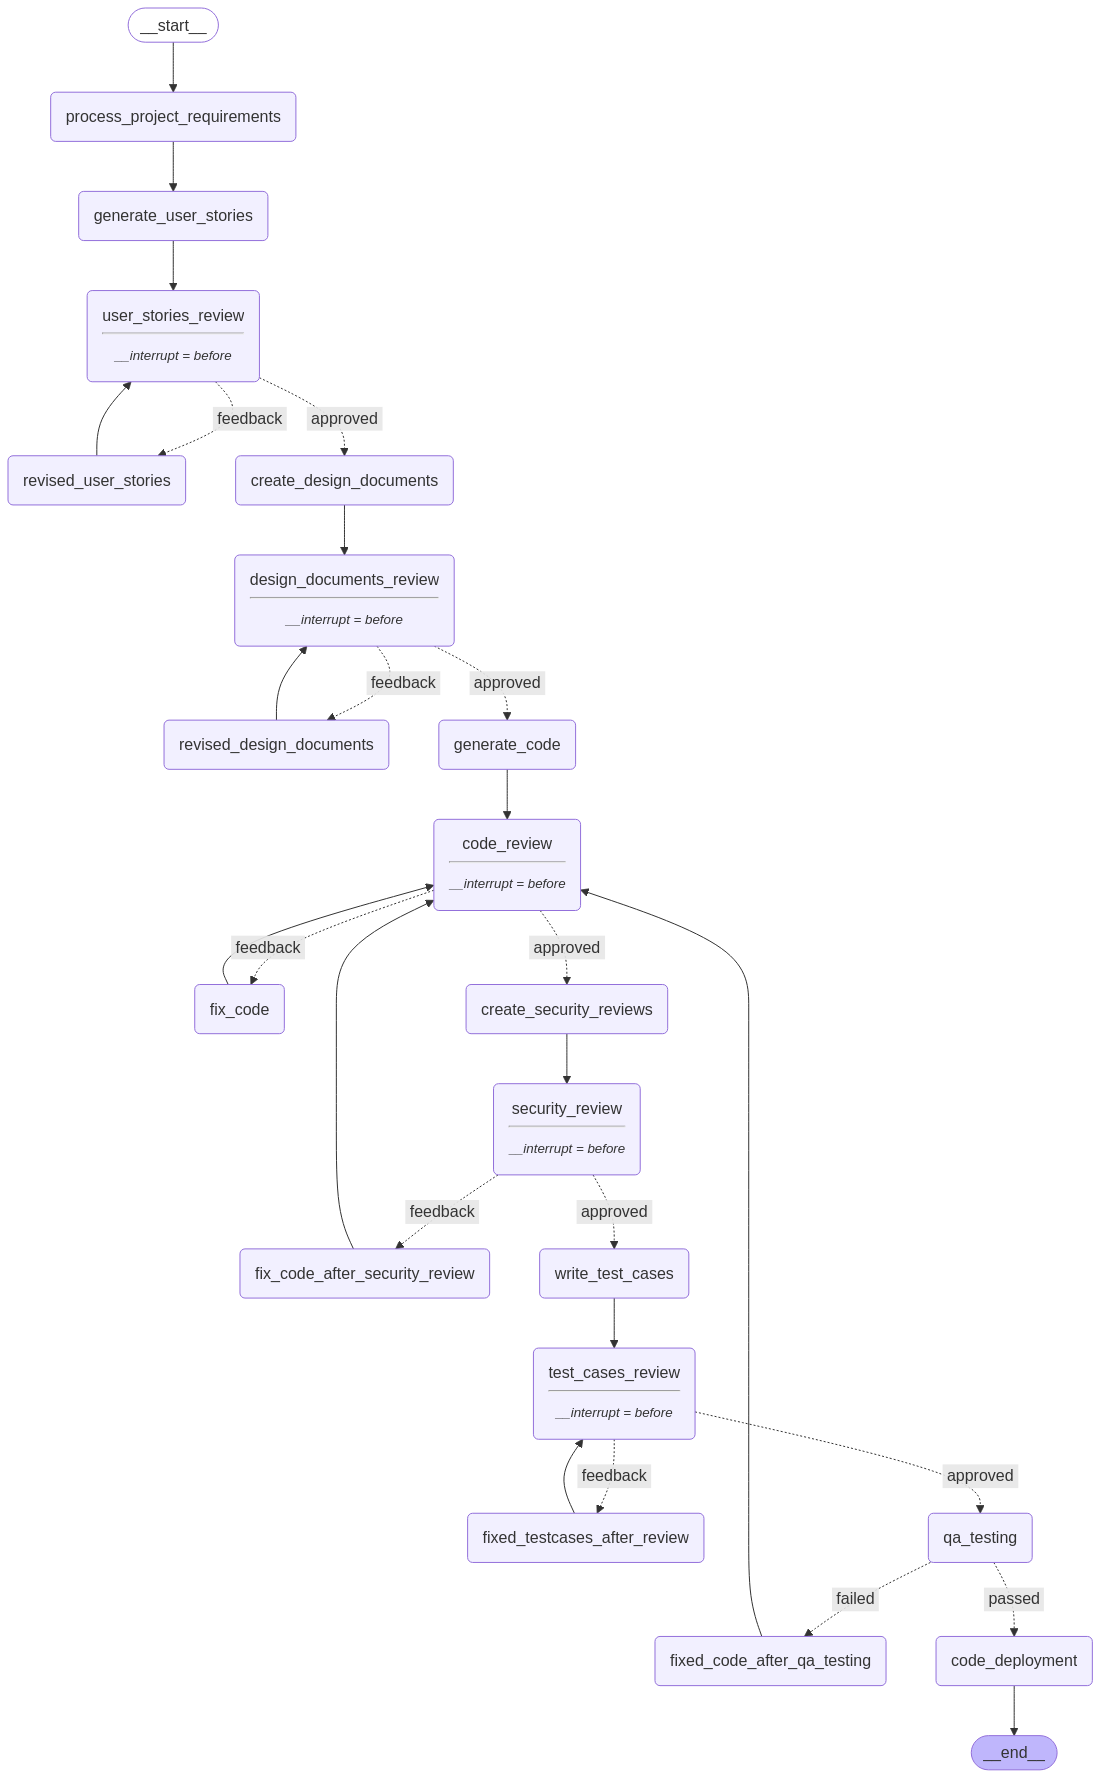

In [41]:
from IPython.display import Image, display
display(Image(sdlc_workflow.get_graph().draw_mermaid_png()))

# User stories

In [42]:
project_title = "PayMate: Your Ultimate Payment Companion"
project_description = "PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs."
requirements = ["Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.​", "Enable users to link multiple bank accounts and perform instant fund transfers using UPI.", "Provide users with access to instant micro-loans with minimal documentation.", "Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app."]
requirements_string = "\n".join(requirements)


In [50]:
project_requirements = ProjectRequirements(
    title = project_title,
    description = project_description,
    requirements = requirements
)

initial_story_state = {
    "project_requirements" : project_requirements,
    "user_stories": [],
    "user_story_messages": HumanMessage(content=f"{project_requirements}"),
    "user_story_status": "in_progress",
    "revised_count" : 0
}

# Thread
thread = {"configurable": {"thread_id": "0"}}

state = None
for event in sdlc_workflow.stream(initial_story_state, thread, stream_mode="values"):
    print(event)

# state

{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']), 'user_stories': [], 'user_story_messages': [HumanMessage(content="title='PayMate: Your Ultimate Payment Companion' description='PayMate is a

In [51]:
{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']), 'user_stories': [{'story_id': 'US-001', 'title': 'Secure Account with Multi-Factor Authentication', 'description': 'As a user, I want to secure my account with multi-factor authentication so that my transactions are protected.', 'acceptance_criteria': ['User can enable biometric authentication (fingerprint and facial recognition).', 'User can set up MPIN for additional security.', 'User can enable two-factor authentication for transactions.', 'System alerts user of authentication failures.']}], 'user_story_messages': [HumanMessage(content="title='PayMate: Your Ultimate Payment Companion' description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.' requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']", additional_kwargs={}, response_metadata={}, id='254e6cce-7ac1-4332-817d-b1963574633f'), AIMessage(content="I've received your project requirements. I'll now generate user stories based on these requirements.", additional_kwargs={}, response_metadata={}, id='13431a84-3525-496b-b58b-4f3839bd93f7'), AIMessage(content="Based on your requirements, I've generated 1 user stories. Please review these user stories and provide feedback or type 'Approved' if you're satisfied.", additional_kwargs={}, response_metadata={}, id='dac5b786-b6b5-4feb-8aa8-47b7650d91ca')], 'user_story_status': 'pending_approval', 'functional_messages': [], 'technical_messages': [], 'frontend_messages': [], 'backend_messages': [], 'revised_count': 0, 'security_reviews_messages': [], 'test_cases_messages': []}


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure Account with Multi-Factor Authentication',
   'description': 'As a user, I want

In [52]:
current_state = sdlc_workflow.get_state(thread) 
current_state.next

('user_stories_review',)

In [49]:
user_feedback = "Add user story to buy insurance from the app"

# sdlc_workflow.update_state(thread, { "user_story_messages" : HumanMessage(content=f'{user_feedback}')})
sdlc_workflow.update_state(thread, { "user_story_messages" : HumanMessage(content='approved')}, as_node="human_feedback")

for event in sdlc_workflow.stream(initial_story_state, thread, stream_mode="values"):
    state = event

state

In process_project_requirements...
In generate_user_stories...


{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure Account with Multi-Factor Authentication',
   'description': 'As a user, I want

In [46]:
state

{'project_requirements': ProjectRequirements(title='PayMate: Your Ultimate Payment Companion', description='PayMate is a comprehensive payment application that allows users to perform seamless transactions using the Unified Payments Interface (UPI). Beyond basic payments, PayMate offers features such as quick loans, bill payments, and a user-friendly interface, making it a one-stop solution for all financial needs.', requirements=['Implement multi-factor authentication, including biometrics (fingerprint and facial recognition) and MPIN, to secure user accounts.\u200b', 'Enable users to link multiple bank accounts and perform instant fund transfers using UPI.', 'Provide users with access to instant micro-loans with minimal documentation.', 'Allow users to pay utility bills such as electricity, water, gas, and broadband directly through the app.']),
 'user_stories': [{'story_id': 'US-001',
   'title': 'Secure Account with Multi-Factor Authentication',
   'description': 'As a user, I want